In [2]:
%load_ext autoreload
%autoreload 2

In [107]:
import sys
import pandas as pd
from enum import Enum

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
sys.path.append("..")

from src.cloud_recognition.model_selection import train_test_split_filenames
from src.cloud_recognition.data_loaders import FlattenedRGBImageLoader
from src.cloud_recognition.data_preparation import filter_black_spots

In [5]:
# Set variables
filenames_filepath = "satellite-images-clouds.csv"
folder_path = "E:/Data/remote_sensing/satellite-images"
column_to_train_test_split_on = "location"
minimal_brightnesses = [500, 600, 700, 800, 900, 1000, 1100, 1200]
minimal_fraction_brightnesses = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
minimal_quantiles = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
colours = ["red", "green", "blue"]
colour_quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

In [6]:
filenames_df = pd.read_csv(filenames_filepath)

In [7]:
def plot_hist(filename:str, folder_path:str):
    image_loader = FlattenedRGBImageLoader(
        filename=filename,
        folder_path=folder_path,
        )

    rgb_df = image_loader.load_flattened_rgb_values()
    rgb_df_filtered = filter_black_spots(rgb_df)
    rgb_df_filtered.hist(bins=100)

In [8]:
def get_rgb_df(filename:str, folder_path:str):
    image_loader = FlattenedRGBImageLoader(
        filename=filename,
        folder_path=folder_path,
    )

    rgb_df = image_loader.load_flattened_rgb_values()
    return filter_black_spots(rgb_df)

In [9]:
def get_fraction_bright(df: pd.DataFrame, minimal_brightness: int) -> float:
    return ((df["red"] > minimal_brightness) & (df["green"] > minimal_brightness) & (df["blue"] > minimal_brightness)).mean()

def get_fraction_bright_from_max(df: pd.DataFrame, minimal_fraction_brightness: int) -> float:
    return ((df["red"] > minimal_fraction_brightness*df["red"].max()) & (df["green"] > minimal_fraction_brightness*df["green"].max()) & (df["blue"] > minimal_fraction_brightness*df["blue"].max())).mean()

def get_pixels_bright(df: pd.DataFrame, minimal_brightness: int) -> float:
    return ((df["red"] > minimal_brightness) & (df["green"] > minimal_brightness) & (df["blue"] > minimal_brightness)).sum()

def get_fraction_relative_bright(df: pd.DataFrame, minimal_quantile: int) -> float:
    red_quantile = df["red"].quantile(minimal_quantile)
    green_quantile = df["green"].quantile(minimal_quantile)
    blue_quantile = df["blue"].quantile(minimal_quantile)
    return ((df["red"] > red_quantile) & (df["green"] > green_quantile) & (df["blue"] > blue_quantile)).mean()

def get_fraction_colour_bright(df: pd.DataFrame, minimal_brightness: int, colour: str) -> float:
    return (df[colour] > minimal_brightness).mean()

def get_number_of_pixels(df: pd.DataFrame) -> int:
    return len(df)

In [10]:
def engineer_features(df: pd.DataFrame):
    output = [get_fraction_bright(df, minimal_brightness=minimal_brightness) for minimal_brightness in minimal_brightnesses]
    output += [get_fraction_relative_bright(df, minimal_quantile=minimal_quantile) for minimal_quantile in minimal_quantiles]
    output += [get_fraction_colour_bright(df, minimal_brightness=minimal_brightness, colour=colour) for minimal_brightness in minimal_brightnesses for colour in colours]
    output += [df[colour].mean() for colour in colours]
    output += [df[colour].quantile(quantile) for quantile in colour_quantiles for colour in colours]
    output += [get_pixels_bright(df, minimal_brightness=minimal_brightness) for minimal_brightness in minimal_brightnesses]
    output += [get_number_of_pixels(df)]
    output += [get_fraction_bright_from_max(df, minimal_fraction_brightness=minimal_fraction_brightness) for minimal_fraction_brightness in minimal_fraction_brightnesses]
    return tuple(output)

In [11]:
feature_columns = [f"fraction_bright_{brightness}" for brightness in minimal_brightnesses]
feature_columns += [f"fraction_relative_bright_{quantile}" for quantile in minimal_quantiles]
feature_columns += [f"fraction_{colour}_bright_{brightness}" for brightness in minimal_brightnesses for colour in colours]
feature_columns += [f"{colour}_mean" for colour in colours]
feature_columns += [f"{colour}_quantile{quantile}" for quantile in colour_quantiles for colour in colours]
feature_columns += [f"number_bright_pixels_{brightness}" for brightness in minimal_brightnesses]
feature_columns += ["number_of_pixels"]
feature_columns += [f"fraction_bright_from_max_{brightness}" for brightness in minimal_fraction_brightnesses]


In [22]:
results = filenames_df.apply(
    lambda row: engineer_features(get_rgb_df(filename=row["filename"], folder_path=folder_path)),
    axis=1
)
for i in range(0,len(feature_columns)):
    filenames_df[feature_columns[i]] = results.str[i]

In [25]:
# filenames_df.to_csv("cache/filenames_df.csv", index=False)
filenames_df = pd.read_csv("cache/filenames_df.csv")

In [27]:
train_df, test_df = train_test_split_filenames(filenames_df, column_to_split_on=None, random_state=1000, train_size=0.7)
# train_df, test_df = train_test_split_filenames(filenames_df, column_to_split_on=column_to_train_test_split_on, random_state=1337, train_size=0.7)

In [166]:
train_df[["location", "clouds","fraction_bright_from_max_0.5","fraction_bright_500"]].sort_values(["location", "clouds"])

,location,clouds,fraction_bright_from_max_0.5,fraction_bright_500
2,coepelduynen,False,6.635786e-07,6.078248e-02
3,coepelduynen,False,1.778391e-05,1.049450e-01
4,coepelduynen,False,1.161545e-01,1.131383e-01
9,coepelduynen,False,1.639570e-03,1.275377e-01
10,coepelduynen,False,5.884622e-04,1.424511e-01
0,coepelduynen,True,1.569987e-02,2.493089e-01
1,coepelduynen,True,3.677752e-02,2.635178e-01
5,coepelduynen,True,1.219345e-06,2.037526e-03
6,coepelduynen,True,2.264498e-06,1.393537e-06
7,coepelduynen,True,1.000000e+00,1.000000e+00


In [124]:
class Location(Enum):
    COEPELDUYNEN = "coepelduynen"
    DUINENGOEREEKWADEHOEK = "duinengoereekwadehoek"
    VOORNESDUIN = "voornesduin"

class ModelType(Enum):
    BASELINE = "baseline"
    LINEAR_MODEL = "linear_model"
    HAND_MADE_MODEL = "hand_made_model"

class Natura2000CloudDetectionModel:
    def __init__(self, model_type: ModelType, linear_models: dict = None):
        self.model_type = model_type
        self.scalers = {loc: StandardScaler() for loc in Location}
        self.pcas = {loc: PCA(n_components=4) for loc in Location}
        self.models = linear_models

    def predict(self, df: pd.DataFrame) -> pd.Series:
        outputs = []
        for loc in Location:
            location_mask = df["location"] == loc.value
            if self.model_type == ModelType.BASELINE:
                location_output = self.predict_baseline(df[location_mask])
            elif self.model_type == ModelType.HAND_MADE_MODEL:
                location_output = self.predict_hand_made_model(df[location_mask], location=loc)
            elif self.model_type == ModelType.LINEAR_MODEL:
                location_output = self.predict_linear_model(df[location_mask], location=loc)
            outputs += [location_output]
        output = pd.concat(outputs)
        return output.loc[df.index]
    
    def predict_baseline(self, df: pd.DataFrame) -> pd.Series:
        return pd.Series([False] * len(df), index=df.index)
    
    def predict_hand_made_model(self, df: pd.DataFrame, location: Location) -> pd.Series:
        if location == Location.COEPELDUYNEN:
            return df["fraction_bright_800"] > 0.01
        elif location == Location.DUINENGOEREEKWADEHOEK:
            return (df["fraction_bright_600"] < 0.0002) | ((df["red_mean"] > 500) & (df["green_mean"] > 500))
        elif location == Location.VOORNESDUIN:
            return df["fraction_bright_500"] > 0.02
        else:
            ValueError("Location value unknown.")
        
    def predict_linear_model(self, df: pd.DataFrame, location: Location) -> pd.Series:
        location_df = df.drop("location", axis=1)
        location_df = self.scalers[location].transform(location_df)
        location_df = self.pcas[location].transform(location_df)
        return pd.Series(self.models[location].predict(location_df), index=df.index)
            
        
    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        for loc in Location:
            location_mask = X_train["location"] == loc.value
            location_df = X_train[location_mask]
            location_df = location_df.drop("location", axis=1)
            location_y = y_train[location_mask]

            location_df = self.scalers[loc].fit_transform(location_df)
            location_df = self.pcas[loc].fit_transform(location_df)
            self.models[loc].fit(location_df, location_y)


In [125]:
feature_columns_to_fit = feature_columns + ["location"]
X_train = train_df[feature_columns_to_fit]
y_train = train_df["clouds"].astype(int)
X_test = test_df[feature_columns_to_fit]
y_test = test_df["clouds"].astype(int)

linear_models = {
    Location.COEPELDUYNEN: LogisticRegression(),
    Location.DUINENGOEREEKWADEHOEK: LogisticRegression(),
    Location.VOORNESDUIN: DecisionTreeClassifier()
}
model = Natura2000CloudDetectionModel(model_type=ModelType.LINEAR_MODEL, linear_models=linear_models)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("train confusion matrix")
print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))
print(accuracy_score(y_train, y_pred_train))
print("test confusion matrix")
print(confusion_matrix(y_true=y_test, y_pred=y_pred_test))
print(accuracy_score(y_test, y_pred_test))

train confusion matrix
[[31  1]
 [ 4 17]]
0.9056603773584906
test confusion matrix
[[11  3]
 [ 0  9]]
0.8695652173913043


In [83]:
X_train = train_df[["location", "fraction_bright_800", "fraction_bright_600", "fraction_bright_500", "red_mean", "green_mean"]]
y_train = train_df["clouds"]
X_test = test_df[["location", "fraction_bright_800", "fraction_bright_600", "fraction_bright_500", "red_mean", "green_mean"]]
y_test = test_df["clouds"]

model = Natura2000CloudDetectionModel(model_type=ModelType.HAND_MADE_MODEL)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("train confusion matrix")
print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))
print((y_pred_train==y_train).mean())
train_df[y_pred_train != y_train]

train confusion matrix
[[27  5]
 [ 9 12]]
0.7358490566037735


C:\Users\pzhadmin\AppData\Local\Temp\2\ipykernel_8176\2717272536.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  output = pd.concat([output, location_output])


,filename,location,clouds,fraction_bright_500,fraction_bright_600,fraction_bright_700,fraction_bright_800,fraction_bright_900,fraction_bright_1000,fraction_bright_1100,...,number_bright_pixels_1000,number_bright_pixels_1100,number_bright_pixels_1200,number_of_pixels,fraction_bright_from_max_0.5,fraction_bright_from_max_0.6,fraction_bright_from_max_0.7,fraction_bright_from_max_0.8,fraction_bright_from_max_0.9,fraction_bright_from_max_0.99
56,20211015_111551_SV1-03_SV_RD_11bit_RGBI_50cm_O...,duinengoereekwadehoek,True,8.028480e-03,4.848130e-03,1.471608e-03,2.840612e-07,5.681225e-08,0.000000e+00,0.000000e+00,...,0,0,0,17601838,8.170567e-03,5.307287e-03,2.122562e-03,3.221255e-05,5.681225e-08,5.681225e-08
75,20220922_110939_SV1-03_SV_RD_11bit_RGBI_50cm_B...,duinengoereekwadehoek,False,1.087431e-03,5.861756e-06,2.855727e-06,1.127261e-06,3.757536e-07,2.254522e-07,0.000000e+00,...,3,0,0,13306592,3.006029e-06,1.202412e-06,6.763565e-07,3.006029e-07,2.254522e-07,7.515072e-08
27,20220514_114854_SV1-02_SV_RD_11bit_RGBI_50cm_R...,coepelduynen,True,5.088342e-01,1.174442e-01,3.908344e-03,5.124153e-04,2.256167e-06,6.635785e-07,1.327157e-07,...,5,1,1,7534904,4.211188e-02,7.459949e-04,2.787030e-06,5.308628e-07,1.327157e-07,1.327157e-07
26,20220501_111418_SV1-03_SV_RD_11bit_RGBI_50cm_R...,coepelduynen,False,2.072844e-01,1.222006e-01,6.172899e-02,1.246439e-02,1.074997e-04,1.831477e-05,7.166647e-06,...,138,54,28,7534904,3.006143e-03,3.397522e-05,1.380243e-05,4.114186e-06,1.061726e-06,0.000000e+00
11,20190601_105844_SV1-04_50cm_RD_11bit_RGBI_Katw...,coepelduynen,False,2.436324e-01,1.598763e-01,8.918152e-02,1.888160e-02,7.896586e-05,3.716040e-05,1.977464e-05,...,280,149,92,7534902,4.485792e-05,1.526231e-05,5.175913e-06,1.459873e-06,3.981472e-07,1.327157e-07
12,20191130_110721_SV1-01_50cm_RD_11bit_RGBI_Rijn...,coepelduynen,True,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0,0,0,7534904,1.281277e-02,7.240968e-04,3.065732e-05,1.459873e-06,1.327157e-07,1.327157e-07
5,20221111_111014_SV1-04_SV_RD_11bit_RGBI_50cm_R...,coepelduynen,True,2.037526e-03,3.588359e-05,4.006420e-06,1.567730e-06,8.709609e-07,6.967687e-07,3.483844e-07,...,4,2,2,5740786,1.219345e-06,6.967687e-07,3.483844e-07,3.483844e-07,1.741922e-07,1.741922e-07
29,20200311_110846_SV1-01_SV_RD_11bit_RGBI_50cm_H...,voornesduin,True,2.995251e-04,9.282158e-06,3.562061e-06,5.200088e-07,2.600044e-08,2.600044e-08,0.000000e+00,...,1,0,0,38460884,3.382658e-05,4.342074e-06,1.274022e-06,5.200088e-08,2.600044e-08,2.600044e-08
21,20210709_103835_SV1-01_SV_RD_11bit_RGBI_50cm_K...,coepelduynen,True,1.819171e-01,1.041853e-01,4.888131e-02,2.291204e-03,1.154627e-05,7.299363e-06,2.256167e-06,...,55,17,5,7534904,2.441969e-05,5.441343e-06,7.962942e-07,3.981471e-07,2.654314e-07,1.327157e-07
13,20191202_110525_SV1-04_50cm_RD_11bit_RGBI_Katw...,coepelduynen,True,1.706724e-04,3.264806e-05,1.035182e-05,6.635785e-06,5.574059e-06,4.777765e-06,3.981471e-06,...,36,30,23,7534904,3.981471e-06,2.521598e-06,1.061726e-06,6.635785e-07,2.654314e-07,1.327157e-07


In [33]:
test_df[y_pred_test != y_test][[f"fraction_bright_from_max_{fraction}" for fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]]]

,fraction_bright_from_max_0.5,fraction_bright_from_max_0.6,fraction_bright_from_max_0.7,fraction_bright_from_max_0.8,fraction_bright_from_max_0.9,fraction_bright_from_max_0.99
74,1.608647e-06,1.035451e-06,6.286666e-07,2.773529e-07,7.396078e-08,0.000000e+00
6,2.264498e-06,1.219345e-06,8.709609e-07,5.225765e-07,3.483844e-07,1.741922e-07
25,9.290098e-07,7.962942e-07,3.981471e-07,3.981471e-07,3.981471e-07,1.327157e-07
43,1.552696e-03,6.640341e-04,1.227849e-04,8.732924e-08,3.493170e-08,1.746585e-08


In [121]:
feature_columns_to_fit = feature_columns
location = "voornesduin"
location_mask_train = train_df["location"] == location
location_mask_test = test_df["location"] == location
X_train = train_df[location_mask_train][feature_columns_to_fit]
y_train = train_df[location_mask_train]["clouds"].astype(int)
X_test = test_df[location_mask_test][feature_columns_to_fit]
y_test = test_df[location_mask_test]["clouds"].astype(int)

In [122]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [123]:
for model in [LogisticRegression(), DecisionTreeClassifier()]:
    print(model)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("train confusion matrix")
    print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))
    print("test confusion matrix")
    print(confusion_matrix(y_true=y_test, y_pred=y_pred_test))
    print(model.score(X_test, y_test))


LogisticRegression()
train confusion matrix
[[1 2]
 [1 5]]
test confusion matrix
[[1 3]
 [1 4]]
0.5555555555555556
DecisionTreeClassifier()
train confusion matrix
[[3 0]
 [0 6]]
test confusion matrix
[[1 3]
 [0 5]]
0.6666666666666666


In [226]:

train_df[y_pred_train != y_train]

,filename,location,clouds,fraction_bright,fraction_bright_500,fraction_bright_600,fraction_bright_700,fraction_bright_800,fraction_bright_900,fraction_bright_1000,...,green_quantile0.99,blue_quantile0.99,number_bright_pixels_500,number_bright_pixels_600,number_bright_pixels_700,number_bright_pixels_800,number_bright_pixels_900,number_bright_pixels_1000,number_bright_pixels_1100,number_bright_pixels_1200
5,20221111_111014_SV1-04_SV_RD_11bit_RGBI_50cm_R...,coepelduynen,True,0.002038,0.002038,0.000036,0.000004,0.000002,8.709609e-07,6.967687e-07,...,497.0,466.0,11697,206,23,9,5,4,2,2
14,20200523_110107_SV1-01_SV_RD_11bit_RGBI_50cm_R...,voornesduin,True,0.030942,0.030942,0.009673,0.000816,0.000022,1.045324e-05,3.484414e-06,...,658.0,654.0,1669446,521889,44003,1184,564,188,61,20
15,20200613_110935_SV1-01_SV_RD_11bit_RGBI_50cm_R...,voornesduin,True,0.048540,0.048540,0.023272,0.010803,0.004787,1.827867e-03,2.996131e-05,...,770.0,727.0,2780079,1332899,618725,274167,104689,1716,304,89


In [152]:
selection_from_model = SelectFromModel(model, prefit=True, )
selection_from_model.transform(X_train).shape

c:\Users\pzhadmin\anaconda3\envs\satellite-images-nso-datascience\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(21, 17)

In [159]:
train_df[["clouds"] + feature_columns].corr()

,clouds,fraction_bright_500,fraction_bright_600,fraction_bright_700,fraction_bright_800,fraction_bright_900,fraction_bright_1000,fraction_bright_1100,fraction_bright_1200,fraction_relative_bright_0.5,...,blue_quantile0.5,red_quantile0.75,green_quantile0.75,blue_quantile0.75,red_quantile0.9,green_quantile0.9,blue_quantile0.9,red_quantile0.99,green_quantile0.99,blue_quantile0.99
clouds,1.000000,0.342891,0.338003,0.326139,0.310935,0.281541,0.255900,0.240650,0.231881,-0.119807,...,0.301980,0.324182,0.328907,0.303701,0.335120,0.328704,0.303617,0.365787,0.357760,0.330306
fraction_bright_500,0.342891,1.000000,0.982644,0.972425,0.940426,0.867093,0.794247,0.749431,0.722120,0.102529,...,0.864643,0.883595,0.881556,0.888763,0.900040,0.906338,0.929483,0.922715,0.934716,0.969362
fraction_bright_600,0.338003,0.982644,1.000000,0.996862,0.968321,0.895839,0.821970,0.776338,0.748299,-0.030030,...,0.870661,0.894190,0.874183,0.879476,0.903969,0.886028,0.906077,0.921711,0.907099,0.942286
fraction_bright_700,0.326139,0.972425,0.996862,1.000000,0.982662,0.921281,0.854230,0.811865,0.785548,-0.049589,...,0.894183,0.914051,0.891620,0.897838,0.918844,0.895043,0.914491,0.930072,0.905641,0.938839
fraction_bright_800,0.310935,0.940426,0.968321,0.982662,1.000000,0.977273,0.935477,0.905585,0.886126,-0.027554,...,0.956670,0.967953,0.947277,0.952242,0.965232,0.937037,0.948091,0.963353,0.924731,0.938340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
green_quantile0.9,0.328704,0.906338,0.886028,0.895043,0.937037,0.949120,0.933094,0.916712,0.905151,0.225912,...,0.973892,0.980050,0.992152,0.987284,0.988979,1.000000,0.993100,0.980090,0.972608,0.952065
blue_quantile0.9,0.303617,0.929483,0.906077,0.914491,0.948091,0.949936,0.926896,0.906902,0.893345,0.211332,...,0.973619,0.973874,0.985177,0.989191,0.981247,0.993100,1.000000,0.974025,0.969777,0.967894
red_quantile0.99,0.365787,0.922715,0.921711,0.930072,0.963353,0.963673,0.939115,0.918264,0.904186,0.143433,...,0.969568,0.983252,0.979241,0.974027,0.989590,0.980090,0.974025,1.000000,0.982500,0.963116
green_quantile0.99,0.357760,0.934716,0.907099,0.905641,0.924731,0.911880,0.880168,0.856123,0.840598,0.267059,...,0.929896,0.944321,0.956270,0.950502,0.958099,0.972608,0.969777,0.982500,1.000000,0.984565


In [140]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

[Text(0.4, 0.875, 'X[1] <= -0.218\ngini = 0.494\nsamples = 9\nvalue = [5, 4]'),
 Text(0.2, 0.625, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.6, 0.625, 'X[1] <= -0.116\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.4, 0.375, 'X[1] <= -0.21\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.375, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

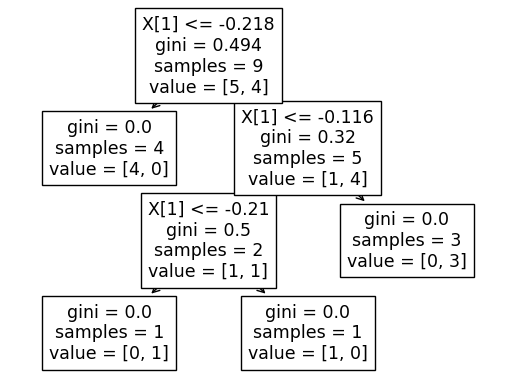

In [210]:
from sklearn.tree import plot_tree
plot_tree(model)

In [119]:
feature_columns[0]

'fraction_bright_500'

array([[10,  0],
       [ 0, 11]], dtype=int64)

In [44]:
get_fraction_bright(rgb_df_no_cloud)

0.06078247600300574

In [17]:
train_df[train_df["clouds"]]["filename"].iloc[0]

'20190302_105726_SV1-01_50cm_RD_11bit_RGBI_Warmond_natura2000_coepelduynen_cropped_ndvi_height.tif'

In [18]:
train_df[~train_df["clouds"]]["filename"].iloc[0]

'20190308_111644_SV1-01_50cm_RD_11bit_RGBI_Oegstgeest_natura2000_coepelduynen_cropped_ndvi_height.tif'

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
dtype: object

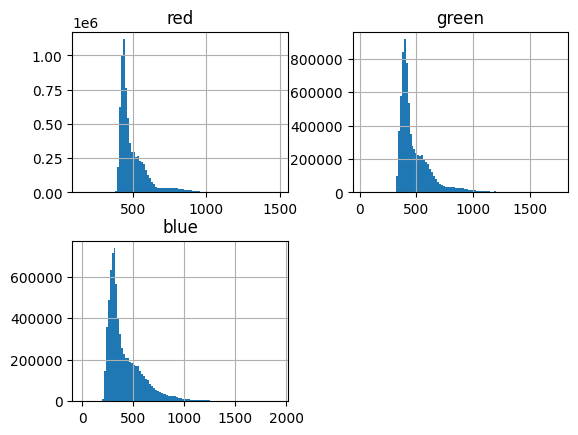

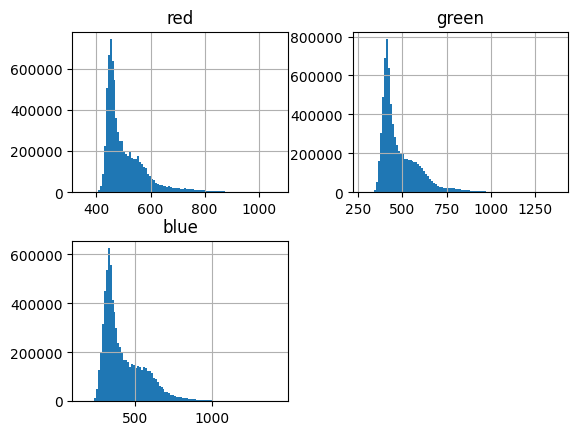

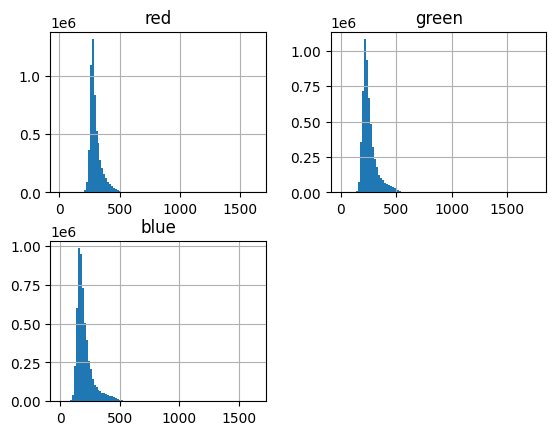

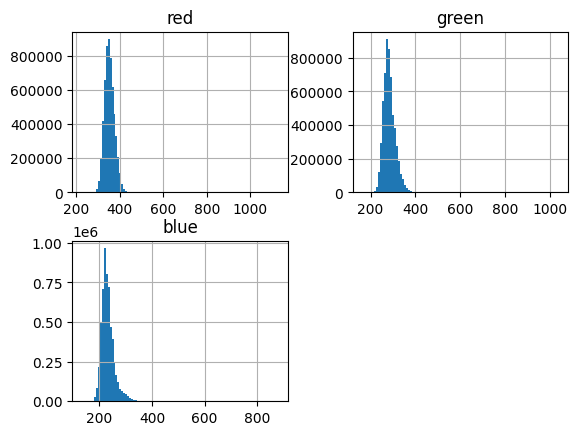

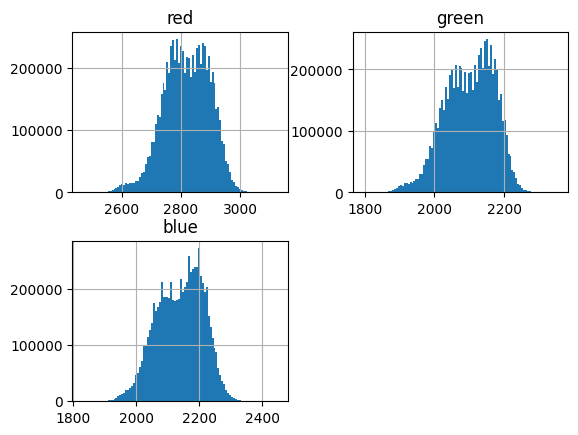

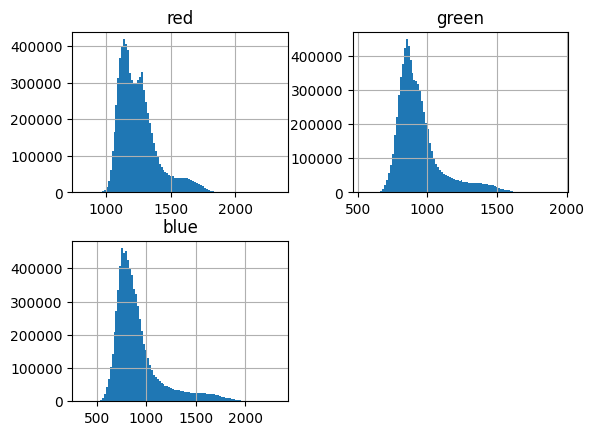

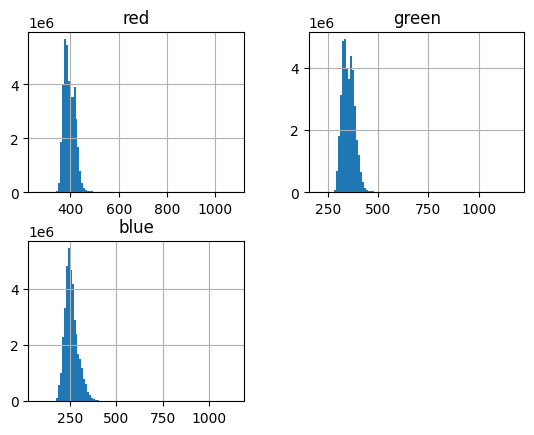

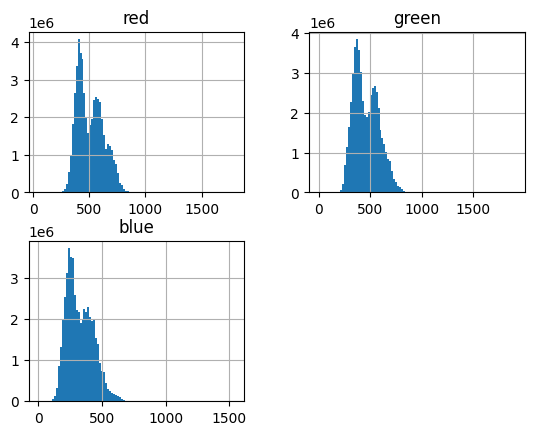

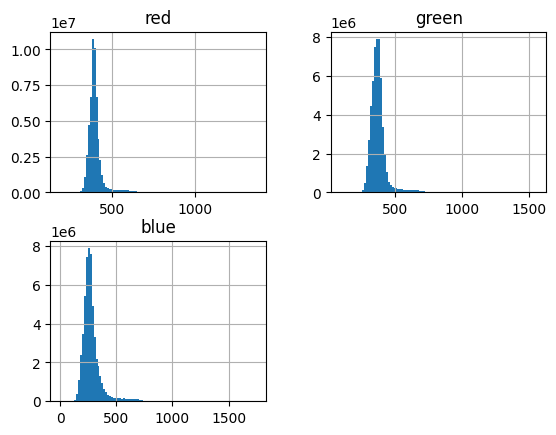

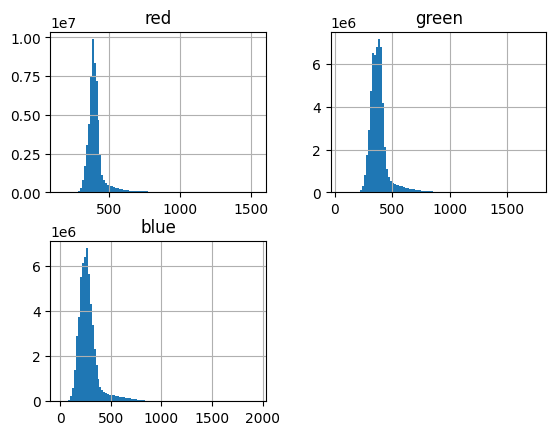

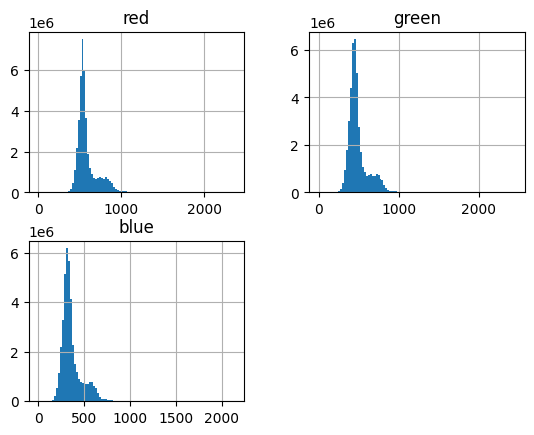

In [8]:
train_df.apply(lambda row: plot_hist(filename=row["filename"], folder_path=folder_path) if row["clouds"] else None, axis=1)



0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
dtype: object

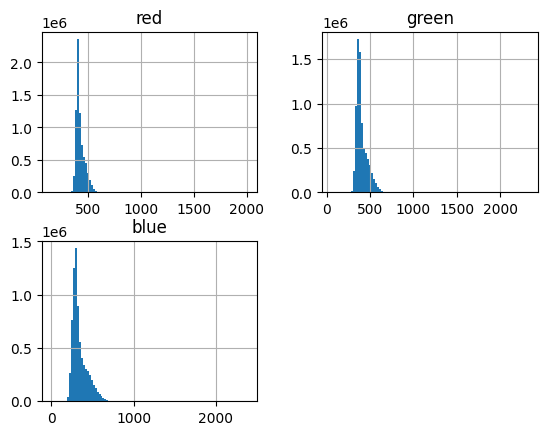

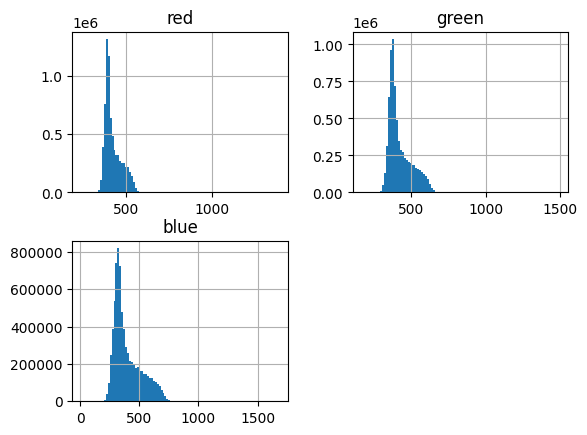

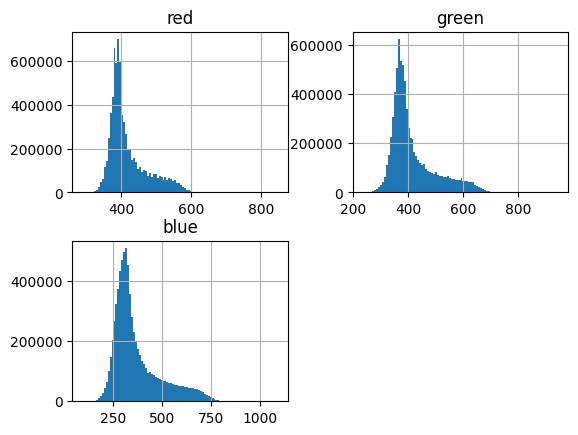

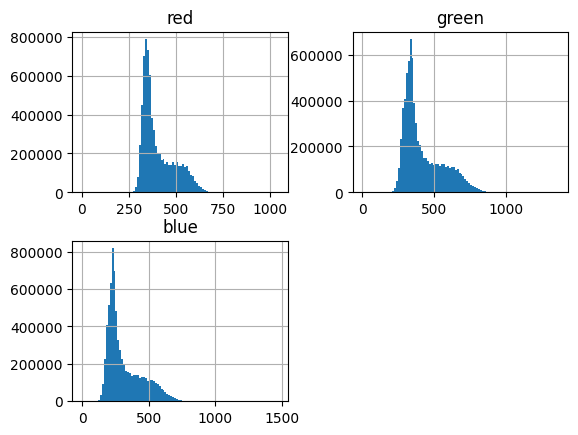

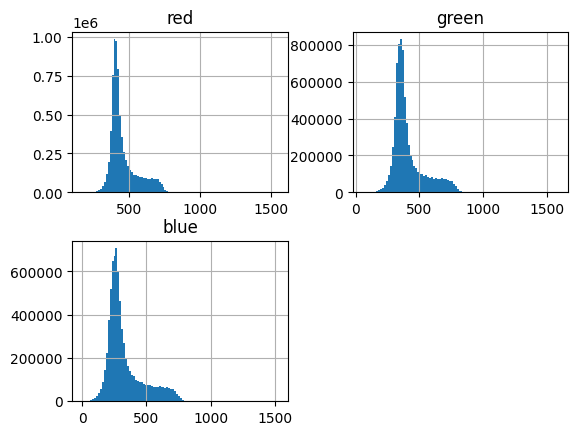

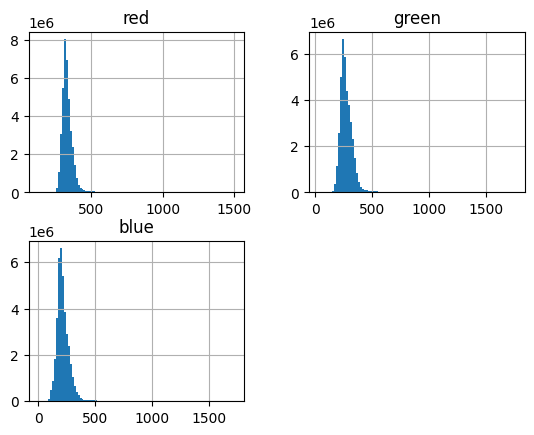

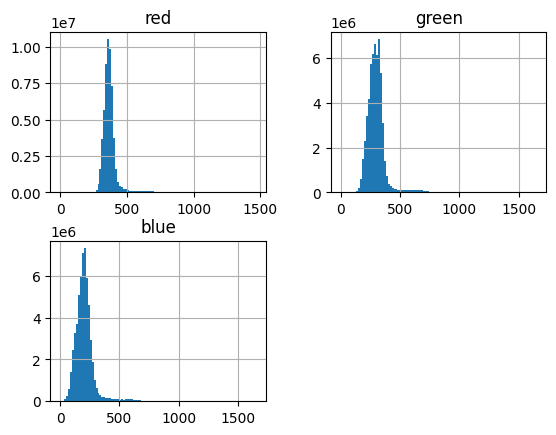

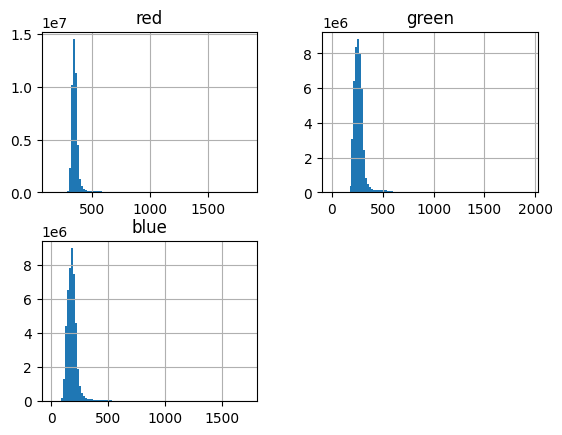

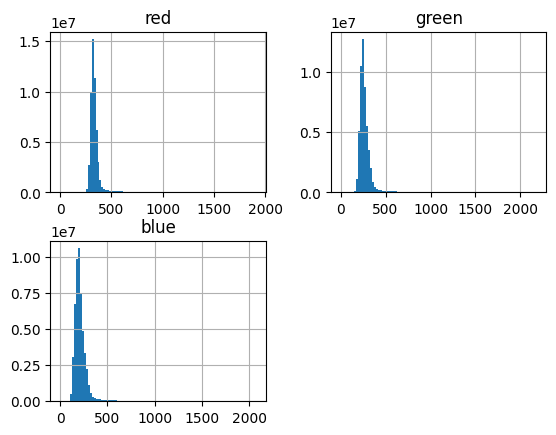

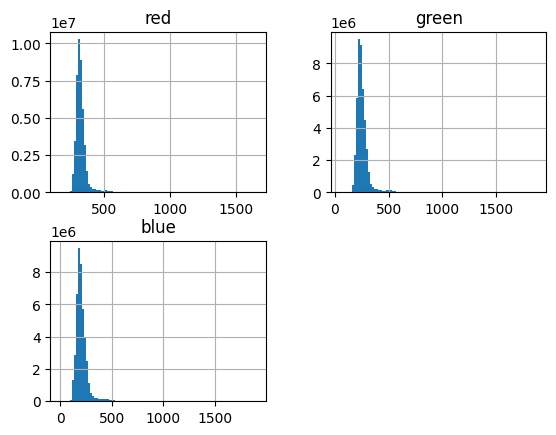

In [9]:
train_df.apply(lambda row: plot_hist(filename=row["filename"], folder_path=folder_path) if not row["clouds"] else None, axis=1)